In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

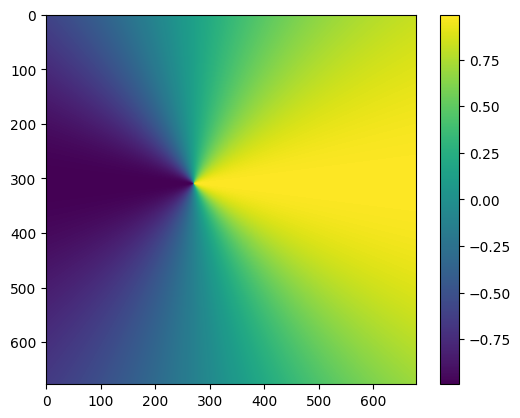

In [53]:

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)
alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2


plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()

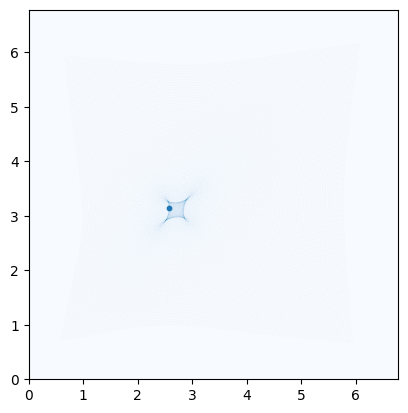

In [5]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()

# define source position
beta_x, beta_y = 2.5673469387755103, 3.1510204081632653
plt.scatter(beta_x, beta_y, s =10)

In [6]:
x_grid = np.linspace(0, size-1, size)
x_grid = x_grid * pixscale

In [7]:
# Assuming deflection maps are stored in alpha_x_map and alpha_y_map
# and that they are on a grid defined by x_grid and y_grid

# Set up the interpolated lens model
lens_model_list1 = ['INTERPOL']
kwargs_lens1 = [{'grid_interp_x': x_grid, 'grid_interp_y': x_grid, 'f_': psi_arcsec,
                          'f_x': alpha_x_arcsec, 'f_y': alpha_y_arcsec}]

lensModel_interpol = LensModel(lens_model_list=lens_model_list1)


# Use lens equation solver
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver1 = LensEquationSolver(lensModel_interpol)

# my code
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)

In [8]:
kwargs_mp = {'theta_E': theta_E* pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens = [kwargs_mp]
solver = LensEquationSolver(lensModel)

# SIE model first guess (Checked, same as INTERPOL first guess)
possible_solutions_analytical = solver.candidate_solutions(beta_x, beta_y, kwargs_lens,verbose= True)
print(possible_solutions_analytical)

# SIE model solution
real_sol = solver.image_position_from_source(beta_x, beta_y, kwargs_lens)
print(real_sol)

#INTERPOL model solution
real_sol_interpol = solver1.image_position_from_source(beta_x, beta_y, kwargs_lens1)
print(real_sol_interpol)




(array([2.75, 3.05, 3.45, 1.75]), array([2.15, 2.25, 3.45, 3.85]), array([0.0105647 , 0.02551845, 0.01507356, 0.0263295 ]), 0.09999999999999964)
(array([1.73874247, 3.47098526]), array([3.79923508, 3.43336961]))
(array([1.73874608, 3.47096802]), array([3.79923588, 3.43336879]))


In [9]:
# My code first guess
possible_sol_approx = cluster.find_rough_def_pix(beta_x/pixscale, beta_y/pixscale)
print(possible_sol_approx)

# My code clustering
clustering = cluster.clustering(beta_x/pixscale, beta_y/pixscale)
print(len(clustering))

# My code solution
real_sol_approx = cluster.get_image_positions(beta_x, beta_y)
print(real_sol_approx)

test = cluster.get_image_positions_lenstronomy(beta_x,beta_y)
print(test)

[(260, 216), (261, 216), (262, 216), (263, 216), (264, 216), (265, 216), (266, 216), (267, 216), (268, 216), (269, 216), (270, 216), (271, 216), (272, 216), (273, 216), (274, 216), (275, 216), (276, 216), (277, 216), (278, 216), (279, 216), (280, 216), (281, 216), (279, 217), (280, 217), (281, 217), (282, 217), (283, 217), (284, 217), (285, 217), (286, 217), (287, 217), (287, 218), (288, 218), (289, 218), (290, 218), (291, 218), (292, 219), (293, 219), (294, 219), (348, 342), (347, 343), (347, 344), (173, 379), (174, 379), (174, 380), (174, 381), (175, 381)]
3
[(1.7387460781138944, 3.7992358802326307), (3.470968017382935, 3.433368793605805)]
[(1.7387460775801327, 3.799235880277695), (3.470968018076527, 3.433368792004626)]


In [10]:
real_sol_approx = cluster.get_image_positions(beta_x, beta_y)
print(real_sol_approx)


[(1.7387460781328756, 3.7992358802335726), (3.470968017371415, 3.433368793627413)]


In [12]:


test = cluster.get_image_positions_lenstronomy(beta_x,beta_y)
print(test)

[(1.7387460775801327, 3.799235880277695), (3.470968018076527, 3.433368792004626)]


[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0), (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0)]


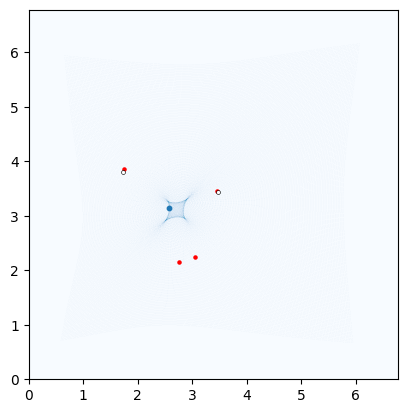

In [10]:
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()

plt.scatter(beta_x, beta_y, s = 10)

plt.scatter(possible_solutions_analytical[0], possible_solutions_analytical[1], s=5, c='r')
#plt.scatter(real_sol[0], real_sol[1], s=5, c='y')
plt.scatter(real_sol_interpol[0], real_sol_interpol[1], s=5, c='k')


cmap = plt.colormaps.get_cmap('Set1')
colors = [cmap(i) for i in range(len(clustering))]
print(colors)
'''
for i in range(0, len(clustering)):
    color = colors[i]
    for j in range(0, len(clustering[i])):
        plt.scatter(clustering[i][j][0]* pixscale, clustering[i][j][1]*pixscale, s=5, c = color)
'''

#for i in range(0, len(possible_sol_approx)):
    #plt.scatter(possible_sol_approx[i][0]*pixscale, possible_sol_approx[i][1]*pixscale, s=5, c = 'g')
for i in range(0, len(real_sol_approx)):
    plt.scatter(real_sol_approx[i][0], real_sol_approx[i][1], s=2, c = 'w')

In [9]:
wrong_img = (3.470968018076527/pixscale, 3.433368792004626/pixscale)
diff = cluster.diff_interpolate(wrong_img, beta_x/pixscale, beta_y/pixscale)
print(diff)

6.22572090926313e-08


In [89]:
# real lens data test
fits_filex='GCdata/Abell2744/hlsp_frontier_model_abell2744_williams_v4_x-arcsec-deflect.fits'
fits_filey='GCdata/Abell2744/hlsp_frontier_model_abell2744_williams_v4_y-arcsec-deflect.fits'
img_file='GCdata/Abell2744/hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='GCdata/Abell2744/hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul = fits.open(fits_filex)
hdul1 = fits.open(fits_filey)
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(img_file)

In [41]:
pixscale_real = 0.25
datax = hdul[0].data
datay = hdul1[0].data
data_img = hdul_img[0].data
data_mag = hdul_mag[0].data
hdul.close()
hdul1.close()
hdul_img.close()

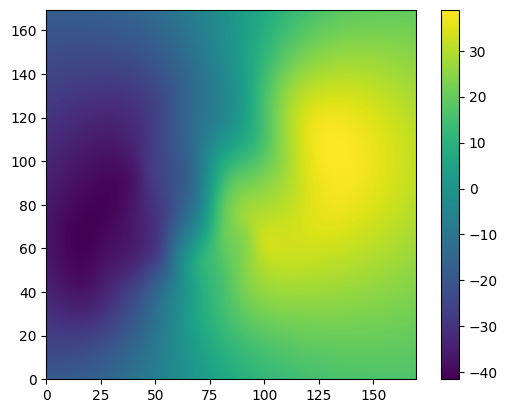

In [42]:
# psi map
psi = 'hlsp_frontier_model_abell2744_williams_v4_psi.fits'
hdul_psi = fits.open(psi)
data_psi = hdul_psi[0].data
data_psi_arcsec = data_psi * pixscale_real**2
hdul_psi.close()
plt.imshow(datax, cmap='viridis', extent=[0, size*pixscale_real, size*pixscale_real,0 ])
plt.gca().invert_yaxis()
plt.colorbar()

In [46]:
realsize = datax.shape[0]
grid = np.linspace(0, realsize-1, realsize)
grid = grid * pixscale_real

In [47]:
lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_arcsec,
                          'f_x': datax, 'f_y': datay}]

lensModel_real = LensModel(lens_model_list=lens_model_list2)
# Use lens equation solver
solver2 = LensEquationSolver(lensModel_real)


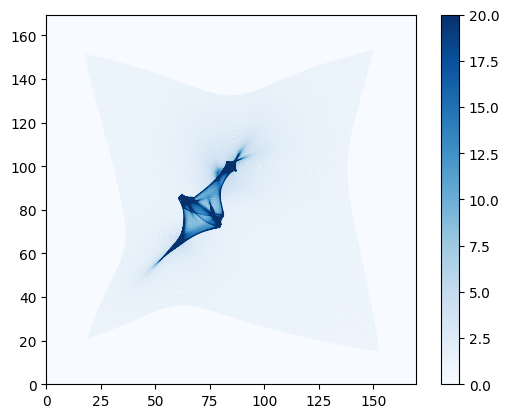

In [48]:
array_test = np.zeros((realsize,realsize))
img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
datax_pix = datax/pixscale_real
datay_pix = datay/pixscale_real


for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay_pix[i,j]
        xcoord = j-datax_pix[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        array_test[yfloor,xfloor] += 1

plt.imshow(array_test, cmap='Blues', vmax = 20, extent=[0, size*pixscale_real, size*pixscale_real,0 ])
plt.gca().invert_yaxis()
plt.colorbar()
print()

In [54]:
print(datax)
print(alpha_x_arcsec)

[[-19.235239 -19.227829 -19.220089 ...  16.570265  16.566704  16.563093]
 [-19.312899 -19.305681 -19.298138 ...  16.610268  16.606638  16.60296 ]
 [-19.390818 -19.383831 -19.37651  ...  16.650324  16.646618  16.642859]
 ...
 [-17.930937 -17.93134  -17.931671 ...  19.527372  19.520452  19.513552]
 [-17.876963 -17.877253 -17.877478 ...  19.46747   19.460617  19.453798]
 [-17.822985 -17.823198 -17.823345 ...  19.40754   19.400686  19.39386 ]]
[[-0.58991407 -0.58822104 -0.58652015 ...  0.81661355  0.81720649
   0.81779673]
 [-0.591387   -0.58969535 -0.58799581 ...  0.81739016  0.81798145
   0.81857004]
 [-0.59286348 -0.59117324 -0.58947508 ...  0.81816711  0.81875676
   0.81934369]
 ...
 [-0.65351736 -0.65234547 -0.6511688  ...  0.6952264   0.69622943
   0.69722829]
 [-0.65265331 -0.65148112 -0.65030415 ...  0.69411161  0.69511653
   0.69611728]
 [-0.6517914  -0.6506189  -0.64944165 ...  0.69299778  0.69400457
   0.6950072 ]]


In [87]:
coord = (63.8, 84.1)
real_sol = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=pixscale_real, search_window=100, verbose=False, x_center=75, y_center=80)
print(real_sol)
sol_approx = cluster.get_image_positions(coord[0], coord[1])
print(sol_approx)

(array([25.04527574, 80.3895084 , 89.83823507, 70.3500693 , 62.87531747,
       63.56479705, 78.41485862]), array([96.30394225, 51.47812429, 71.45908221, 59.92729871, 45.81923451,
       52.27263524, 72.34180586]))
[(25.045275744297914, 96.30394225190294), (62.875317463935346, 45.81923450711856), (63.56479704672153, 52.27263523781894), (70.35006929653217, 59.9272987057208), (78.41485861525571, 72.34180585660076), (80.3895083920782, 51.478124287607045), (89.83823507368415, 71.45908220449867)]


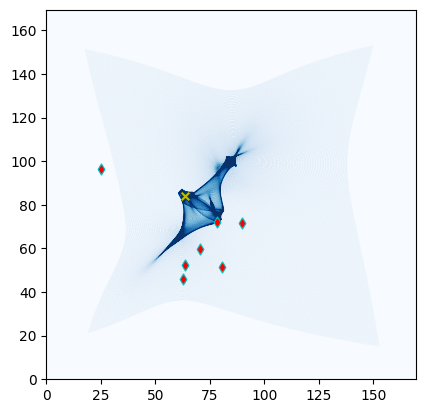

In [88]:
plt.scatter(coord[0], coord[1], s=30, c='y', marker = 'x')
plt.scatter(real_sol[0], real_sol[1], s=30, c='c', marker = 'd')
for i in range(0, len(sol_approx)):
    plt.scatter(sol_approx[i][0], sol_approx[i][1], s=10, c = 'r', marker = 'd')
plt.imshow(array_test, cmap='Blues', vmax = 20, extent=[0, size*pixscale_real, size*pixscale_real,0 ])
plt.gca().invert_yaxis()